# Ubicaciones.xlsx -> (ubi_cliente)

In [1]:
import re
import numpy as np
import logging
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
import unicodedata

In [2]:
# 1. Leer el archivo Excel
print("1. Leyendo el archivo Excel...")
ruta = "../Sucia/Ubicaciones.xlsx"
df_ubicaciones = pd.read_excel(ruta, sheet_name='Ubicacion', engine='openpyxl')
print("Datos leídos con éxito. Muestra de datos antes de la limpieza:")
df_ubicaciones.info()
df_ubicaciones.head(2)

1. Leyendo el archivo Excel...
Datos leídos con éxito. Muestra de datos antes de la limpieza:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   CODIGO     748 non-null    int64         
 1   CODIGO2    748 non-null    object        
 2   UBICACIÓN  747 non-null    object        
 3   FECHA      748 non-null    datetime64[ns]
 4   ORIGEN     748 non-null    object        
 5   CODCLI2    748 non-null    int64         
 6   TAREAS     0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 41.0+ KB


,CODIGO,CODIGO2,UBICACIÓN,FECHA,ORIGEN,CODCLI2,TAREAS
0,80313,"80313,SOL Y AGU","http://maps.google.com/?q=-34.770816,-55.575468",2024-12-14,agregados_adrian,80313,NaN
1,80315,"80315,CASA NEPTUNO","http://maps.google.com/?q=-34.782554,-55.556325",2024-12-14,agregados_adrian,80315,NaN


# Aca Simplificas: 1_ el excell ya no tiene todos los codigos de la columna tareas. 2_ Eliminando el bloque 1: Carga inicial y limpieza basica donde haciamos una limpieza eliminando las filas donde no habia codigos en tareas. Resultado? antes nos quedaban 527 filas y ahora 748. Te dejo la imagen de lo que borraste, aunque se que ya lo sabes. Y de paso agrego el archivo ipynb que usabamos antes tambien. Se llama 01_OneDrive_Ubicaciones_Clientes_ORIGINAL


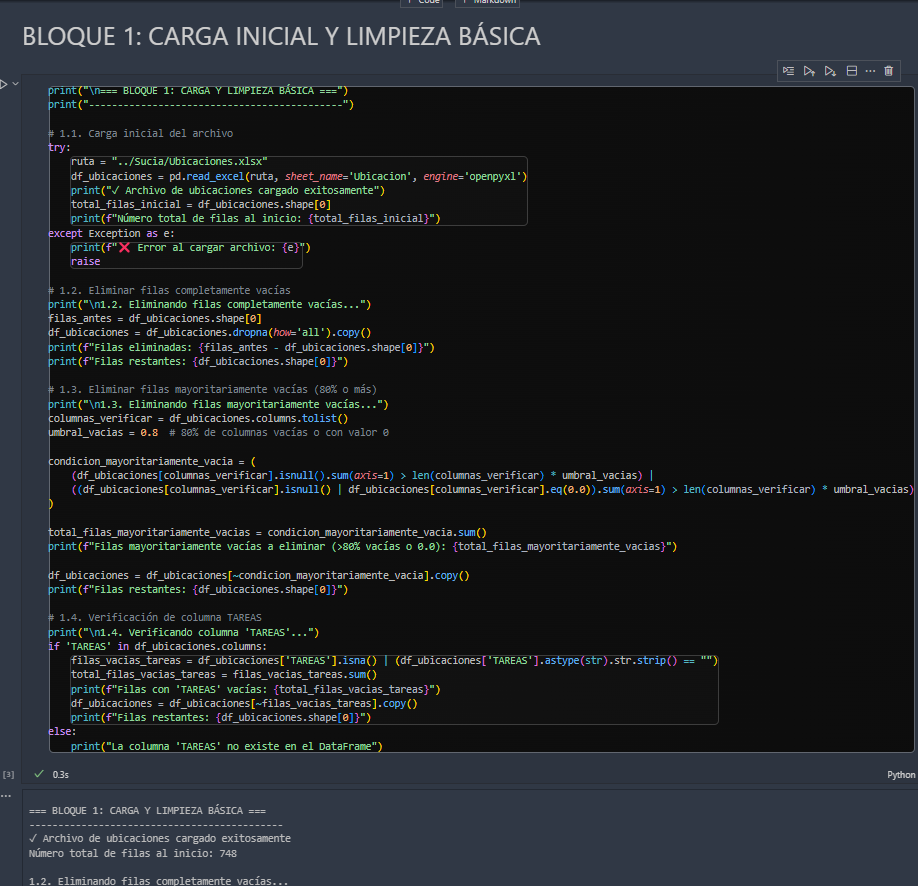

In [3]:
# Dejo solo los que tienen ubicaciones. 

df_ubicaciones = df_ubicaciones.dropna(subset=['UBICACIÓN'])

In [4]:
df_ubicaciones.info()

<class 'pandas.core.frame.DataFrame'>
Index: 747 entries, 0 to 747
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   CODIGO     747 non-null    int64         
 1   CODIGO2    747 non-null    object        
 2   UBICACIÓN  747 non-null    object        
 3   FECHA      747 non-null    datetime64[ns]
 4   ORIGEN     747 non-null    object        
 5   CODCLI2    747 non-null    int64         
 6   TAREAS     0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 46.7+ KB


## BLOQUE 2:  PROCESAMIENTO DE NOMBRES Y CÓDIGOS 

**Observaciones df_ubicaciones** 
- La columna CODIGO2, incluye nombres, vamos a dejarlo con el nombre NOMCLI.
- La columna UBICACION contiene los enlaces con coordenadas a Google Map podriamos proceder creando una columna Latitud y otra Longitud.
  
**Procedemos a ejecutar lo descrito:**

In [5]:
df_ubicaciones.rename(columns={'CODIGO2': 'NOMCLI'}, inplace=True)

## BLOQUE 3: PROCESAMIENTO DE UBICACIONES

In [6]:
def extract_coordinates(ubicacion):
    if pd.isna(ubicacion):
        return pd.Series({
            'LATITUD': None, 
            'LONGITUD': None, 
            'RAZON_COORDENADAS': 'Ubicación nula'
        })

    ubicacion = str(ubicacion)
    patterns = [
        r'lat/lng:\s*\(\s*(-?\d+\.\d+),\s*(-?\d+\.\d+)\s*\)',
        r'lat/lng:\s*(-?\d+\.\d+),\s*(-?\d+\.\d+)',
        r'http[s]?://maps\.google\.com/\?q\s*=\s*(-?\d+\.\d+)\s*,\s*(-?\d+\.\d+)',
        r'@(-?\d+\.\d+),\s*(-?\d+\.\d+)',
        r'q=(-?\d+\.\d+),\s*(-?\d+\.\d+)',
        r'!3d\s*(-?\d+\.\d+)!4d\s*(-?\d+\.\d+)',
        r'https?://maps\.app\.goo\.gl/[^?]*\?q=(-?\d+\.\d+),\s*(-?\d+\.\d+)',
    ]

    for pattern in patterns:
        match = re.search(pattern, ubicacion)
        if match:
            try:
                lat = float(match.group(1))
                lon = float(match.group(2))
                return pd.Series({
                    'LATITUD': lat, 
                    'LONGITUD': lon, 
                    'RAZON_COORDENADAS': 'Coordenadas extraídas'
                })
            except ValueError:
                return pd.Series({
                    'LATITUD': None, 
                    'LONGITUD': None, 
                    'RAZON_COORDENADAS': 'Error en conversión de coordenadas'
                })

    # Búsqueda de coordenadas adicional
    all_coords = re.findall(r'(-?\d+\.\d+)', ubicacion)
    if len(all_coords) >= 2:
        try:
            lat = float(all_coords[0])
            lon = float(all_coords[1])
            return pd.Series({
                'LATITUD': lat, 
                'LONGITUD': lon, 
                'RAZON_COORDENADAS': 'Coordenadas alternativas extraídas'
            })
        except ValueError:
            pass

    return pd.Series({
        'LATITUD': None, 
        'LONGITUD': None, 
        'RAZON_COORDENADAS': 'No se encontraron coordenadas'
    })

# Proceso de extracción
df_ubicaciones[['LATITUD', 'LONGITUD', 'RAZON_COORDENADAS']] = df_ubicaciones['UBICACIÓN'].apply(extract_coordinates)

# Análisis de resultados
print("Resumen de extracción de coordenadas:")
print(df_ubicaciones['RAZON_COORDENADAS'].value_counts())

# Exportar filas problemáticas
filas_problematicas = df_ubicaciones[df_ubicaciones['LATITUD'].isna()]
filas_problematicas.to_excel('ubicaciones_sin_coordenadas.xlsx', index=False)

Resumen de extracción de coordenadas:
RAZON_COORDENADAS
Coordenadas extraídas            741
No se encontraron coordenadas      6
Name: count, dtype: int64


In [7]:
filas_problematicas.head(8)

,CODIGO,NOMCLI,UBICACIÓN,FECHA,ORIGEN,CODCLI2,TAREAS,LATITUD,LONGITUD,RAZON_COORDENADAS
152,100006,CASA LAUTARO,https://maps.app.goo.gl/RdKDZfi5WDGPKMkt9,2024-09-05,agregados_adrian,100006,NaN,NaN,NaN,No se encontraron coordenadas
185,100000,EMPRESA,https://maps.app.goo.gl/TJdD7rTMyTRzzCbY7,2024-08-07,agregados_adrian,100000,NaN,NaN,NaN,No se encontraron coordenadas
186,100001,CASA DARIO,https://maps.app.goo.gl/RYAzoCFef6kyb2sb7,2024-08-07,agregados_adrian,100001,NaN,NaN,NaN,No se encontraron coordenadas
188,100003,CASA CONRADO,https://maps.app.goo.gl/cJZv8DexaNKHfXJN6,2024-08-07,agregados_adrian,100003,NaN,NaN,NaN,No se encontraron coordenadas
189,100004,CASA MIGUEL,https://maps.app.goo.gl/VAukkvZeqQn3iVS48,2024-08-07,agregados_adrian,100004,NaN,NaN,NaN,No se encontraron coordenadas
190,100005,CASA MARTIN,https://maps.app.goo.gl/uBJ6PMaBsF6tTWXz9,2024-08-07,agregados_adrian,100005,NaN,NaN,NaN,No se encontraron coordenadas


Los demas codigos(100001 a 100006) son referidos a ubicacion empresa y los tenemos en nuestro set **ubi_empresa.xlsx**

## BLOQUE 4: LIMPIEZA FINAL Y GUARDAD

In [8]:
# 4.1. Crear DataFrame final
print("\n4.1. Creando DataFrame final...")
ubi_cliente = df_ubicaciones[['CODIGO', 'NOMCLI', 'LATITUD', 'UBICACIÓN', 'LONGITUD', 'FECHA']].copy()

# 4.2. Conversiones finales
print("\n4.2. Realizando conversiones finales...")
ubi_cliente['LONGITUD'] = pd.to_numeric(ubi_cliente['LONGITUD'], errors='coerce')
ubi_cliente['LATITUD'] = pd.to_numeric(ubi_cliente['LATITUD'], errors='coerce')
ubi_cliente['NOMCLI'] = ubi_cliente['NOMCLI'].astype(str)
ubi_cliente['CODIGO'] = ubi_cliente['CODIGO'].astype('int64')

# 4.3. Limpiezas finales
print("\n4.3. Realizando limpiezas finales...")
filas_antes_limpieza = ubi_cliente.shape[0]
ubi_cliente = ubi_cliente.dropna(subset=['LATITUD', 'LONGITUD', 'UBICACIÓN', 'CODIGO', 'NOMCLI'])
ubi_cliente = ubi_cliente.drop_duplicates(subset=['NOMCLI'])
ubi_cliente.reset_index(drop=True, inplace=True)

# 4.4. Reportes finales
print("\n4.4. Generando reportes finales...")
zero_coords = ubi_cliente[(ubi_cliente['LATITUD'] == 0) & (ubi_cliente['LONGITUD'] == 0)]
print(f"Registros con coordenadas en 0: {len(zero_coords)}")

# 4.5. Guardar resultados
print("\n4.5. Guardando resultados...")
try:
    ruta_salida = "../Limpia/Ubicaciones_direcciones.xlsx"
    with pd.ExcelWriter(ruta_salida) as writer:
        ubi_cliente.to_excel(writer, sheet_name='Ubicaciones_Limpias', index=False)
        if not zero_coords.empty:
            zero_coords.to_excel(writer, sheet_name='Coordenadas_En_0', index=False)
    print(f"✓ Archivo guardado exitosamente en: {ruta_salida}")
except Exception as e:
    print(f"❌ Error al guardar: {e}")
    raise

print("\n=== PROCESO COMPLETADO ===")



4.1. Creando DataFrame final...

4.2. Realizando conversiones finales...

4.3. Realizando limpiezas finales...

4.4. Generando reportes finales...
Registros con coordenadas en 0: 0

4.5. Guardando resultados...
✓ Archivo guardado exitosamente en: ../Limpia/Ubicaciones_direcciones.xlsx

=== PROCESO COMPLETADO ===


In [9]:
df_ubicaciones.info()
df_ubicaciones.sample(5)

<class 'pandas.core.frame.DataFrame'>
Index: 747 entries, 0 to 747
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   CODIGO             747 non-null    int64         
 1   NOMCLI             747 non-null    object        
 2   UBICACIÓN          747 non-null    object        
 3   FECHA              747 non-null    datetime64[ns]
 4   ORIGEN             747 non-null    object        
 5   CODCLI2            747 non-null    int64         
 6   TAREAS             0 non-null      float64       
 7   LATITUD            741 non-null    float64       
 8   LONGITUD           741 non-null    float64       
 9   RAZON_COORDENADAS  747 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 64.2+ KB


,CODIGO,NOMCLI,UBICACIÓN,FECHA,ORIGEN,CODCLI2,TAREAS,LATITUD,LONGITUD,RAZON_COORDENADAS
214,42627,"42627, PANADERIA LAS BARRERAS S.A.","Marcador 84\nlat/lng: (-34.7003,-55.88068)\n[h...",2024-04-27,1,42627,NaN,-34.700300,-55.880680,Coordenadas extraídas
459,23065,BETTINA RANCEL // SAN LUIS SUR // L2,"http://maps.google.com/?q=-34.77077715841556,-...",2024-04-27,2,23065,NaN,-34.770777,-55.576314,Coordenadas extraídas
309,22125,UN LUGAR AL SUR,"http://maps.google.com/?q=-34.77014894744767,-...",2024-04-27,2,22125,NaN,-34.770149,-55.592462,Coordenadas extraídas
204,12970,"12970,EL PUNTO JUSTO","Marcador 61\nlat/lng: (-34.77427,-55.8374)\n[h...",2024-04-27,1,12970,NaN,-34.774270,-55.837400,Coordenadas extraídas
462,80110,***UBICACION (poner ubicacion en comentarios)...,"http://maps.google.com/?q=-34.79086802265021,-...",2024-04-27,2,80110,NaN,-34.790868,-55.476940,Coordenadas extraídas
